<a href="https://colab.research.google.com/github/benmellin/ECG-Prediction/blob/main/ECG_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns




In [ ]:
mit_train_df = pd.read_csv("/content/drive/MyDrive/Neural Nets Project/Data/mitbih_train.csv",header=None)
mit_test_df = pd.read_csv("/content/drive/MyDrive/Neural Nets Project/Data/mitbih_test.csv",header=None)

In [ ]:
mit_train_df = pd.read_csv("/content/drive/MyDrive/NN_RAW/mitbih_train.csv",header=None)
mit_test_df = pd.read_csv("/content/drive/MyDrive/NN_RAW/mitbih_test.csv",header=None)

- Data is already normalized, so we can skip this step.

Get the labels, create the validation data set

In [ ]:
train_labels=mit_train_df.iloc[:,-1]
test_labels=mit_test_df.iloc[:,-1]
train_vals = mit_train_df.drop(mit_train_df.columns[-1], axis=1)
test_vals = mit_test_df.drop(mit_test_df.columns[-1], axis=1)

## Creating a validation set by taking .2 from training data set.

train_x, val_x, train_y, val_y = train_test_split(train_vals, train_labels, test_size=0.2, random_state=1234)



### A note about data leakage
- The reason I take the validation set from the training set is to prevent data leakage.
- If we take some testing data for our validation set, we are overfitting on the test data, becuase our validation set would contain pateints that are also in the test set.
- Thus, it is best to keep patients in the testing set completely unseen, so we can get a proper estimate of generalizability
- I make the validation data set from the training data for this reason

# Some standard ML methods
- Going to try some standard ML methods (SVM, random forest, KNN) without doing anything to the features of the data
- I will primarily be trying to maximize multiclass macroaveraged recall.
- I'm choosing to maximize this statistic because misclassification in the context of ECG pattern detection is dangerous.
- By maximizing recall, we ultimately aim to miminimize false negatives.
- Classes are also unbalanced here, which is why macroaverage is important.

## KNN

In [ ]:
knn_clf=knn = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(train_x, train_y)

KNeighborsClassifier()

In [ ]:
y_pred = knn_clf.predict(val_x)
accuracy = accuracy_score(val_y, y_pred)
print("Accuracy:", accuracy)
print(classification_report(val_y, y_pred))

Accuracy: 0.9732168351322026
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     14515
         1.0       0.91      0.68      0.78       439
         2.0       0.93      0.89      0.91      1161
         3.0       0.81      0.67      0.73       123
         4.0       0.99      0.95      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.92      0.84      0.87     17511
weighted avg       0.97      0.97      0.97     17511



- Recall is really not so bad, but could be better. We want to maximize this.

In [ ]:
## Using KNN with distance weights

knn_clf=knn = KNeighborsClassifier(n_neighbors=5,weights="distance")
knn_clf.fit(train_x, train_y)

y_pred = knn_clf.predict(val_x)
accuracy = accuracy_score(val_y, y_pred)
print("Accuracy:", accuracy)
print(classification_report(val_y, y_pred))


Accuracy: 0.9743589743589743
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     14515
         1.0       0.92      0.69      0.79       439
         2.0       0.93      0.91      0.92      1161
         3.0       0.80      0.67      0.73       123
         4.0       0.99      0.95      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.92      0.84      0.88     17511
weighted avg       0.97      0.97      0.97     17511



- Didn't help much
- Try to tune the n_neighbors param

In [ ]:
nn_vals=[3, 5, 9, 15, 29] # nn values to try
class_report_dict={}

for nn in nn_vals:

  knn_clf=knn = KNeighborsClassifier(n_neighbors=nn,weights="distance")
  tuned_knn=knn_clf.fit(train_x, train_y)
  tuned_knn.fit(train_x,train_y)
  y_pred = tuned_knn.predict(val_x)

  class_report_dict[nn]=classification_report(val_y, y_pred)


In [ ]:
for nn in class_report_dict:
  print("Neighbors",nn)
  print(class_report_dict[nn])

Neighbors 3
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     14515
         1.0       0.90      0.71      0.79       439
         2.0       0.93      0.92      0.92      1161
         3.0       0.80      0.72      0.76       123
         4.0       0.99      0.96      0.97      1273

    accuracy                           0.98     17511
   macro avg       0.92      0.86      0.89     17511
weighted avg       0.98      0.98      0.98     17511

Neighbors 5
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     14515
         1.0       0.92      0.69      0.79       439
         2.0       0.93      0.91      0.92      1161
         3.0       0.80      0.67      0.73       123
         4.0       0.99      0.95      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.92      0.84      0.88     17511
weighted avg       0.97      0.97      0.97     17511

- Seems like, to minimze recall, our value for nn should be 3.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3,weights = "distance")
tuned_knn = knn.fit(train_x, train_y)
y_pred = tuned_knn.predict(val_x)

In [ ]:
print("\n\t\t-- Classification Report --\n")
print(classification_report(val_y, y_pred))


		-- Classification Report --

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     14515
         1.0       0.90      0.71      0.79       439
         2.0       0.93      0.92      0.92      1161
         3.0       0.80      0.72      0.76       123
         4.0       0.99      0.96      0.97      1273

    accuracy                           0.98     17511
   macro avg       0.92      0.86      0.89     17511
weighted avg       0.98      0.98      0.98     17511



Text(0.5, 1.0, 'KNN Classification Confusion Matrix')

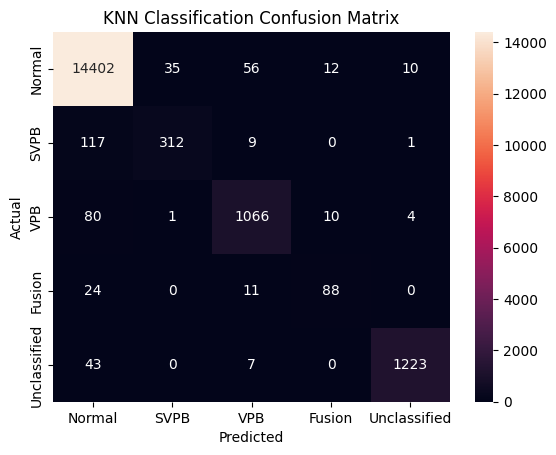

In [ ]:
# Creates the confusion matrix and creates a heatmap for the predictions using said CM
cm = confusion_matrix(val_y, y_pred)
class_labels = ["Normal", "SVPB", "VPB", "Fusion", "Unclassified"]
sns.heatmap(cm, annot = True, fmt = "g", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Classification Confusion Matrix")

### Testing KNN on Test set

In [ ]:
test_y_pred = tuned_knn.predict(test_vals)
test_labels
print("\n\t\t-- Classification Report --\n")
print(classification_report(test_labels, test_y_pred))


		-- Classification Report --

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.87      0.68      0.76       556
         2.0       0.94      0.91      0.93      1448
         3.0       0.79      0.68      0.73       162
         4.0       0.99      0.96      0.97      1608

    accuracy                           0.98     21892
   macro avg       0.91      0.84      0.88     21892
weighted avg       0.97      0.98      0.97     21892



Text(0.5, 1.0, 'KNN Classification Confusion Matrix')

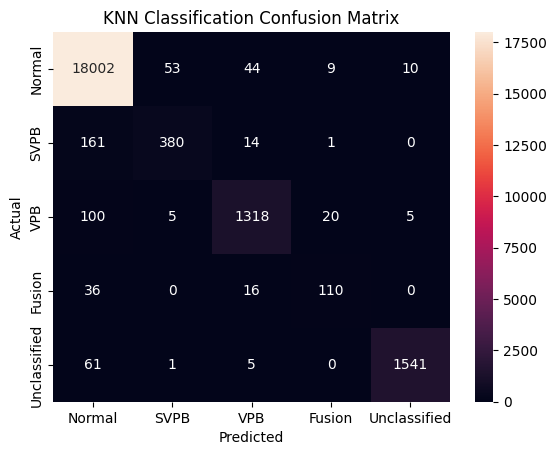

In [ ]:
# Creates the confusion matrix and creates a heatmap for the predictions using said CM
cm = confusion_matrix(test_labels, test_y_pred)
class_labels = ["Normal", "SVPB", "VPB", "Fusion", "Unclassified"]
sns.heatmap(cm, annot = True, fmt = "g", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Classification Confusion Matrix")

## Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=10)
rf_clf = rf_clf.fit(train_x,train_y)

In [ ]:
y_pred = rf_clf.predict(val_x)
accuracy = accuracy_score(val_y, y_pred)
print("Accuracy:", accuracy)
print(classification_report(val_y, y_pred))

Accuracy: 0.9724744446348009
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14515
         1.0       0.96      0.60      0.74       439
         2.0       0.96      0.87      0.92      1161
         3.0       0.90      0.53      0.67       123
         4.0       0.99      0.95      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.96      0.79      0.85     17511
weighted avg       0.97      0.97      0.97     17511



Recall is fairly low for classes 1 and 3.

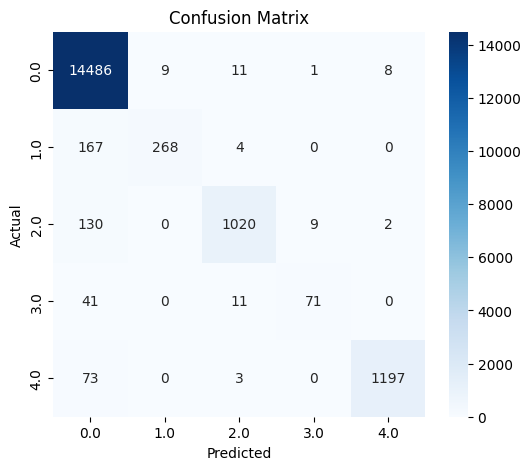

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(val_y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(val_y), yticklabels=set(val_y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


- It is important to make maximize recall in this case--it is generally worse to predict an abnormal heart beat as normal, vs predicting a normal heartbeat as abnormal
- Adjusting weights in random forest, will penalize misclassifying rarer instances more

In [ ]:
rf_clf_weight_balance = RandomForestClassifier(class_weight="balanced", n_estimators=10)
rf_clf_weight_balance  = rf_clf_weight_balance.fit(train_x,train_y)

In [ ]:
y_pred = rf_clf_weight_balance.predict(val_x)
accuracy = accuracy_score(val_y, y_pred)
print("Accuracy:", accuracy)
print(classification_report(val_y, y_pred))

Accuracy: 0.9716178402147222
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14515
         1.0       0.96      0.60      0.74       439
         2.0       0.98      0.85      0.91      1161
         3.0       0.92      0.58      0.71       123
         4.0       1.00      0.94      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.97      0.79      0.86     17511
weighted avg       0.97      0.97      0.97     17511



- This was not so different. Let's try tuning the weights for class_weight

In [ ]:
weight_vals=[5, 25, 50, 250, 750,1000] # weight values to try
class_report_dict={}

for weight in weight_vals:

  weights_dict={0: 1, 1: weight, 2: weight, 3:weight}
  tuned_rf = RandomForestClassifier(class_weight=weights_dict, n_estimators=10)
  tuned_rf.fit(train_x,train_y)
  y_pred = tuned_rf.predict(val_x)

  class_report_dict[weight]=classification_report(val_y, y_pred)





In [ ]:
for weight in class_report_dict:
  print("Weight",weight)
  print(class_report_dict[weight])

Weight 5
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14515
         1.0       0.96      0.61      0.75       439
         2.0       0.98      0.86      0.91      1161
         3.0       0.90      0.51      0.65       123
         4.0       0.99      0.94      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.96      0.78      0.85     17511
weighted avg       0.97      0.97      0.97     17511

Weight 25
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14515
         1.0       0.95      0.62      0.75       439
         2.0       0.98      0.87      0.92      1161
         3.0       0.90      0.56      0.69       123
         4.0       1.00      0.94      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.96      0.80      0.86     17511
weighted avg       0.97      0.97      0.97     17511

Wei

- Doesn't seem like this is is helping too much
- Other approaches could include over/under samping to make the class distributions more even.

In [ ]:
rf_clf_weight_balance = RandomForestClassifier(class_weight="balanced", n_estimators=10)
rf_clf_weight_balance  = rf_clf_weight_balance.fit(train_x,train_y)
y_pred = rf_clf_weight_balance.predict(val_x)
print("\n\t\t-- Classification Report --\n")
print(classification_report(val_y, y_pred))


		-- Classification Report --

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14515
         1.0       0.95      0.61      0.74       439
         2.0       0.97      0.85      0.91      1161
         3.0       0.86      0.57      0.69       123
         4.0       1.00      0.94      0.97      1273

    accuracy                           0.97     17511
   macro avg       0.95      0.79      0.86     17511
weighted avg       0.97      0.97      0.97     17511



Text(0.5, 1.0, 'Random Forest Classification Confusion Matrix')

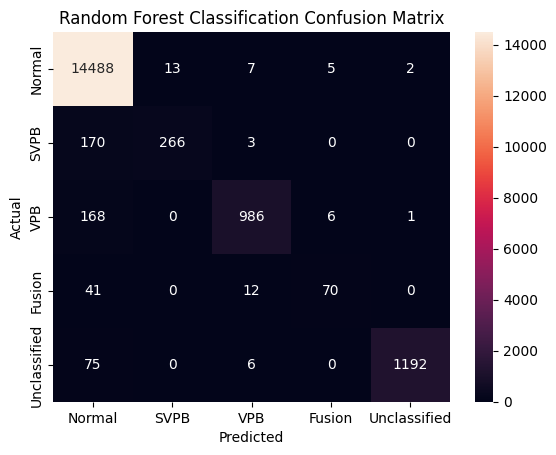

In [ ]:
# Creates the confusion matrix and creates a heatmap for the predictions using said CM
cm = confusion_matrix(val_y, y_pred)
class_labels = ["Normal", "SVPB", "VPB", "Fusion", "Unclassified"]
sns.heatmap(cm, annot = True, fmt = "g", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Classification Confusion Matrix")

## Support Vector Machines

In [ ]:
svc_clf= SVC()
svc_clf=svc_clf.fit(train_x,train_y)

In [ ]:
y_pred = svc_clf.predict(val_x)
accuracy = accuracy_score(val_y, y_pred)
print("Accuracy:", accuracy)
print(classification_report(val_y, y_pred))

Accuracy: 0.9667066415396037
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14515
         1.0       0.94      0.59      0.72       439
         2.0       0.97      0.86      0.91      1161
         3.0       0.73      0.46      0.57       123
         4.0       0.99      0.90      0.94      1273

    accuracy                           0.97     17511
   macro avg       0.92      0.76      0.82     17511
weighted avg       0.97      0.97      0.96     17511



- Very low recall, not so good.
- Hyperparams could be played with here, but it took a while to train so I'm going to try something else

In [ ]:
print("\n\t\t-- Classification Report --\n")
print(classification_report(val_y, y_pred))


		-- Classification Report --

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14515
         1.0       0.94      0.59      0.72       439
         2.0       0.97      0.86      0.91      1161
         3.0       0.73      0.46      0.57       123
         4.0       0.99      0.90      0.94      1273

    accuracy                           0.97     17511
   macro avg       0.92      0.76      0.82     17511
weighted avg       0.97      0.97      0.96     17511



Text(0.5, 1.0, 'SVM Classification Confusion Matrix')

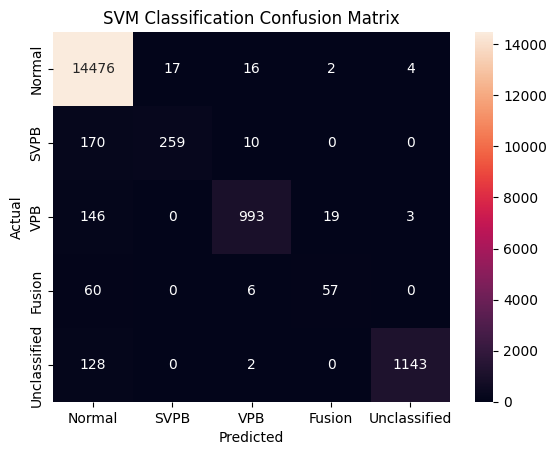

In [ ]:
# Creates the confusion matrix and creates a heatmap for the predictions using said CM
cm = confusion_matrix(val_y, y_pred)
class_labels = ["Normal", "SVPB", "VPB", "Fusion", "Unclassified"]
sns.heatmap(cm, annot = True, fmt = "g", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Classification Confusion Matrix")

## Basic RNN

In [ ]:
# Getting data into right shape for NN

nn_x_train = torch.tensor(train_x.values).float()  # Convert to tensor and float
nn_x_train = nn_x_train.unsqueeze(-1)  # Shape (70000, 187, 1) (adding 1 feature dimension)
nn_x_val = torch.tensor(val_x.values).float()
nn_x_val = nn_x_val.unsqueeze(-1)

# Convert labels to tensor
nn_y_train = torch.tensor(train_y.values).long()
nn_y_val = torch.tensor(val_y.values).long()


In [ ]:
## Compute class weights for imbalanced classes

class_weights = compute_class_weight('balanced', classes=np.array([0,1,2,3,4]), y=train_y)
print(class_weights)
scaling_factor=1
class_weights[-4:] *= scaling_factor
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights=class_weights.to(device) # make sure they are on cuda for the later computation
print(class_weights)


[ 0.24171095  7.85235426  3.02757726 27.04362934  2.71589763]
tensor([ 0.2417,  7.8524,  3.0276, 27.0436,  2.7159], device='cuda:0')


In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleRNN, self).__init__()

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, 128, batch_first=True)

        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 5)

        # Activation functions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(512)  # Batch normalization for hidden layer 1
        self.batch_norm2 = nn.BatchNorm1d(1024)  # Batch normalization for hidden layer 2

    def forward(self, x):
        # Forward pass through the RNN
        out, _ = self.rnn(x)

        # Take the last output (last time step) for classification
        out = out[:, -1, :]  # Extract the last time step

        # Pass through fully connected layers with activation and batch normalization
        out = self.relu(self.batch_norm1(self.fc1(out)))
        out = self.dropout(out)
        out = self.relu(self.batch_norm2(self.fc2(out)))
        out = self.dropout(out)
        out = self.relu(self.batch_norm2(self.fc3(out)))
        out = self.dropout(out)
        out = self.fc4(out)  # No activation before the final output layer

        return out

In [ ]:
input_size = 1  # ECG value per time step

model = SimpleRNN(input_size)


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


- Change your runtime type in top right corner to use GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
print(device)

cuda


In [ ]:
num_epochs = 10  # Number of training epochs
batch_size = 64  # Batch size for training

# Calculate the number of batches
num_batches = len(nn_x_train) // batch_size

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients

    for i in range(num_batches):
        # Get the mini-batch data
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_x = nn_x_train[start_idx:end_idx]
        batch_x = batch_x.to(device)
        batch_y = nn_y_train[start_idx:end_idx]
        batch_y=batch_y.to(device)

        # Forward pass
        outputs = model(batch_x)

        # Compute loss
        loss = criterion(outputs.squeeze(), batch_y.squeeze())  # Squeeze to 1D

        # Backpropagation
        loss.backward()
        optimizer.step()  # Update weights

    # Print loss every  epochs
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [1/10], Loss: 5.7248
Epoch [2/10], Loss: 2.8344
Epoch [3/10], Loss: 2.4208
Epoch [4/10], Loss: 3.1252
Epoch [5/10], Loss: 1.8171
Epoch [6/10], Loss: 1.6441
Epoch [7/10], Loss: 1.6100
Epoch [8/10], Loss: 1.6760
Epoch [9/10], Loss: 1.6944
Epoch [10/10], Loss: 1.6921


In [ ]:
nn_x_val = nn_x_val.to(device)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients during evaluation
    y_pred = model(nn_x_val)
    y_pred = torch.softmax(y_pred,dim=1).round()
    y_pred_arg= torch.argmax(y_pred, dim=1)

    # bring data back to CPU
    y_pred_arg=y_pred_arg.cpu()

    # Print classification report
    print(classification_report(nn_y_val, y_pred_arg))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14515
           1       0.00      0.00      0.00       439
           2       0.00      0.00      0.00      1161
           3       0.01      1.00      0.01       123
           4       0.00      0.00      0.00      1273

    accuracy                           0.01     17511
   macro avg       0.00      0.20      0.00     17511
weighted avg       0.00      0.01      0.00     17511



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


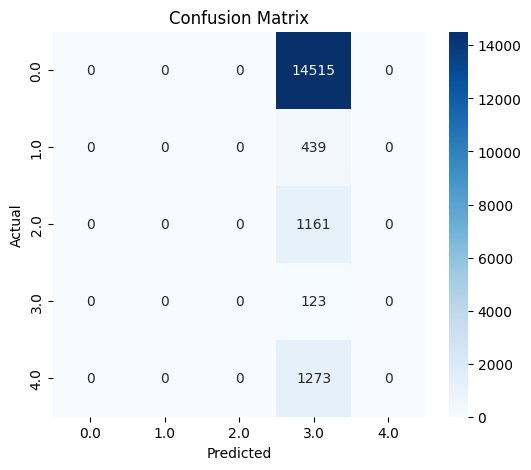

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(nn_y_val, y_pred_arg)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(val_y), yticklabels=set(val_y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- No matter what I do, the model predicts everything as one class. Here is a summary of what I have tried
- Increasing model complexity
- Weighting the classes in the crossentropy loss definition
- adding dropout and batchnorm
